# ChatGPT


### Import Libraries


In [1]:
from openai import OpenAI
from pydantic import BaseModel
from sklearn.metrics import (
    classification_report,
    multilabel_confusion_matrix,
)
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
import enum
import dotenv
import csv
import os

In [2]:
# Path to save the inferences
csv_file_path = "prompt2_4o_inferences_test.csv"

### Load and Preprocess Dataset


In [3]:
opp_115 = pd.read_csv('../../opp_115_test.csv')
opp_115.head()

,segment_id,policy_id,text,label
0,2,1636,Our Web Sites may contain links to other websi...,10
1,5,1361,Yahoo's participation in the Safe Harbor prog...,"6, 9"
2,2,919,Note: A cookie file contains unique informatio...,10
3,23,303,analytics cookies We use a tool called Google...,"2, 1"
4,7,144,"We reserve the right to access, use, and share...","2, 1"


In [4]:
# One-hot encoding of labels
classes = list(range(1, 11))


def to_binary_matrix(y, classes):
    return np.array(
        [[1 if cls in curr_labels else 0 for cls in classes] for curr_labels in y]
    )


y_true = (
    opp_115["label"]
    .apply(lambda x: [int(i) for i in x.split(",")] if isinstance(x, str) else [])
    .tolist()
)
y_true_binary = to_binary_matrix(y_true, classes)
y_true_binary = y_true_binary.astype(bool)

### Load Model and Define Model Configuration


In [5]:
# Define output classes
class Classification(enum.Enum):
    YES = "yes"
    NO = "no"


class ClassificationWithDescription(BaseModel):
    presence: Classification
    description: str


class CategoryClassification(BaseModel):
    first_party_collection_use: Classification
    third_party_sharing_collection: Classification
    user_choice_control: Classification
    user_access_edit_deletion: Classification
    data_retention: Classification
    data_security: Classification
    policy_change: Classification
    do_not_track: Classification
    international_specific_audiences: Classification
    other: Classification


class CategoryClassificationWithDescription(BaseModel):
    first_party_collection_use: ClassificationWithDescription
    third_party_sharing_collection: ClassificationWithDescription
    user_choice_control: ClassificationWithDescription
    user_access_edit_deletion: ClassificationWithDescription
    data_retention: ClassificationWithDescription
    data_security: ClassificationWithDescription
    policy_change: ClassificationWithDescription
    do_not_track: ClassificationWithDescription
    international_specific_audiences: ClassificationWithDescription
    other: ClassificationWithDescription

In [6]:
dotenv.load_dotenv("../.env")
openai_api_key = dotenv.get_key("../.env", "OPENAI_API_KEY")

In [7]:
client = OpenAI()

### Define Categories


In [8]:
category_names = [
    "First Party Collection/Use",
    "Third Party Sharing/Collection",
    "User Choice/Control",
    "User Access, Edit, & Deletion",
    "Data Retention",
    "Data Security",
    "Policy Change",
    "Do Not Track",
    "International & Specific Audiences",
    "Other",
]

category_descriptions = [
    "how and why a service provider collects user information.",
    "how user information may be shared with or collected by third parties.",
    "choices and control options available to users.",
    "if and how users may access, edit, or delete their information.",
    "how long user information is stored.",
    "how user information is protected.",
    "if and how users will be informed about changes to the privacy policy.",
    "if and how Do Not Track signals for online tracking and advertising are honored.",
    "practices that pertain only to a specific group of users (e.g., children, Europeans, or California residents).",
    "includes privacy contact information, introductory or generic text, or data practices not covered in the above categories.",
]

categories_names_str = "\n".join(
    [f"{i+1}. {name}" for i, name in enumerate(category_names)]
)

category_names_with_description_str = "\n".join(
    [
        f"{i+1}. {name}: {description}"
        for i, (name, description) in enumerate(
            zip(category_names, category_descriptions)
        )
    ]
)

### Run the Inferences using Prompt 1


In [9]:
inferences = {}
current_idx = 0
max_idx = len(opp_115)
num_rate_limit_retries = 0

In [10]:
# Check if the there are any exisitng inferences saved in a CSV file
csv_exist = False

if os.path.exists(csv_file_path):
    csv_exist = True

    # Load the CSV file and add the existing inferences to the inferences dictionary
    existing_inferences = pd.read_csv(csv_file_path)

    # Add the existing data to inferences
    for _, row in existing_inferences.iterrows():
        policy_id = row["policy_id"]
        segment_id = row["segment_id"]
        classification = CategoryClassification(
            first_party_collection_use=Classification(
                row["first_party_collection_use"]
            ),
            third_party_sharing_collection=Classification(
                row["third_party_sharing_collection"]
            ),
            user_choice_control=Classification(row["user_choice_control"]),
            user_access_edit_deletion=Classification(row["user_access_edit_deletion"]),
            data_retention=Classification(row["data_retention"]),
            data_security=Classification(row["data_security"]),
            policy_change=Classification(row["policy_change"]),
            do_not_track=Classification(row["do_not_track"]),
            international_specific_audiences=Classification(
                row["international_specific_audiences"]
            ),
            other=Classification(row["other"]),
        )
        inferences[(policy_id, segment_id)] = classification

while current_idx < max_idx:
    policy_id = opp_115.iloc[current_idx]["policy_id"]
    segment_id = opp_115.iloc[current_idx]["segment_id"]

    if (policy_id, segment_id) in inferences:
        current_idx += 1
        continue
    else:
        break

print(f"Starting from index {current_idx}")

Starting from index 2980


In [11]:
# Initialize tqdm progress bar
progress_bar = tqdm(total=max_idx, desc="Running Inferences")
progress_bar.update(current_idx)

# Loop through the records and run the inferences
while current_idx < max_idx:
    try:
        current_record = opp_115.iloc[current_idx]
        text = current_record["text"]
        policy_id = current_record["policy_id"]
        segment_id = current_record["segment_id"]

        if (policy_id, segment_id) in inferences:
            current_idx += 1
            progress_bar.update(1)
            continue

        # Run the inference
        system_prompt = "You are an expert legal language model specializing in privacy policy analysis. Your task is to evaluate a given text segment to determine its relevance to specific privacy policy categories. For each category, provide a structured JSON response indicating whether the text fits the category."
        user_prompt = f"""
Text Segment:
\" {text} \"

Category Names With Descriptions:
{category_names_with_description_str}
            """

        response = client.beta.chat.completions.parse(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt},
            ],
            temperature=0,
            response_format=CategoryClassification,
        )

        # Stores the json response in the inferences dictionary for later use
        inferences[(policy_id, segment_id)] = response.choices[0].message.parsed

        current_idx += 1
        progress_bar.update(1)

    # In case of hitting the rate limit
    except Exception as e:
        print(e)
        if num_rate_limit_retries >= 5:
            print(f"At record {current_idx}")
            break

        time.sleep(random.randint(5, 15))
        num_rate_limit_retries += 1

# Close the progress bar
progress_bar.close()

Running Inferences:   0%|          | 0/2980 [00:00<?, ?it/s]

### Save the Inferences to a CSV


In [18]:
# Define the Columns in the CSV (Header)
header = [
    "policy_id",
    "segment_id",
    "first_party_collection_use",
    "third_party_sharing_collection",
    "user_choice_control",
    "user_access_edit_deletion",
    "data_retention",
    "data_security",
    "policy_change",
    "do_not_track",
    "international_specific_audiences",
    "other",
]

# Convert the inferences dict in a format suitable for csv format
csv_data = []
for (policy_id, segment_id), classification in inferences.items():
    row = [
        policy_id,
        segment_id,
        classification.first_party_collection_use.value,
        classification.third_party_sharing_collection.value,
        classification.user_choice_control.value,
        classification.user_access_edit_deletion.value,
        classification.data_retention.value,
        classification.data_security.value,
        classification.policy_change.value,
        classification.do_not_track.value,
        classification.international_specific_audiences.value,
        classification.other.value,
    ]
    csv_data.append(row)

# Write/Append the data to CSV
with open("prompt2_4o_inferences_test.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(header)
    writer.writerows(csv_data)

print("CSV file created successfully.")

CSV file created successfully.


### Evaluation


In [12]:
# Extract predicted labels from the inferences
y_pred_binary = np.array([
    [
        inferences[(row["policy_id"], row["segment_id"])].first_party_collection_use == Classification.YES,
        inferences[(row["policy_id"], row["segment_id"])].third_party_sharing_collection == Classification.YES,
        inferences[(row["policy_id"], row["segment_id"])].user_choice_control == Classification.YES,
        inferences[(row["policy_id"], row["segment_id"])].user_access_edit_deletion == Classification.YES,
        inferences[(row["policy_id"], row["segment_id"])].data_retention == Classification.YES,
        inferences[(row["policy_id"], row["segment_id"])].data_security == Classification.YES,
        inferences[(row["policy_id"], row["segment_id"])].policy_change == Classification.YES,
        inferences[(row["policy_id"], row["segment_id"])].do_not_track == Classification.YES,
        inferences[(row["policy_id"], row["segment_id"])].international_specific_audiences == Classification.YES,
        inferences[(row["policy_id"], row["segment_id"])].other == Classification.YES,
    ]
    for _, row in opp_115.iterrows()
])

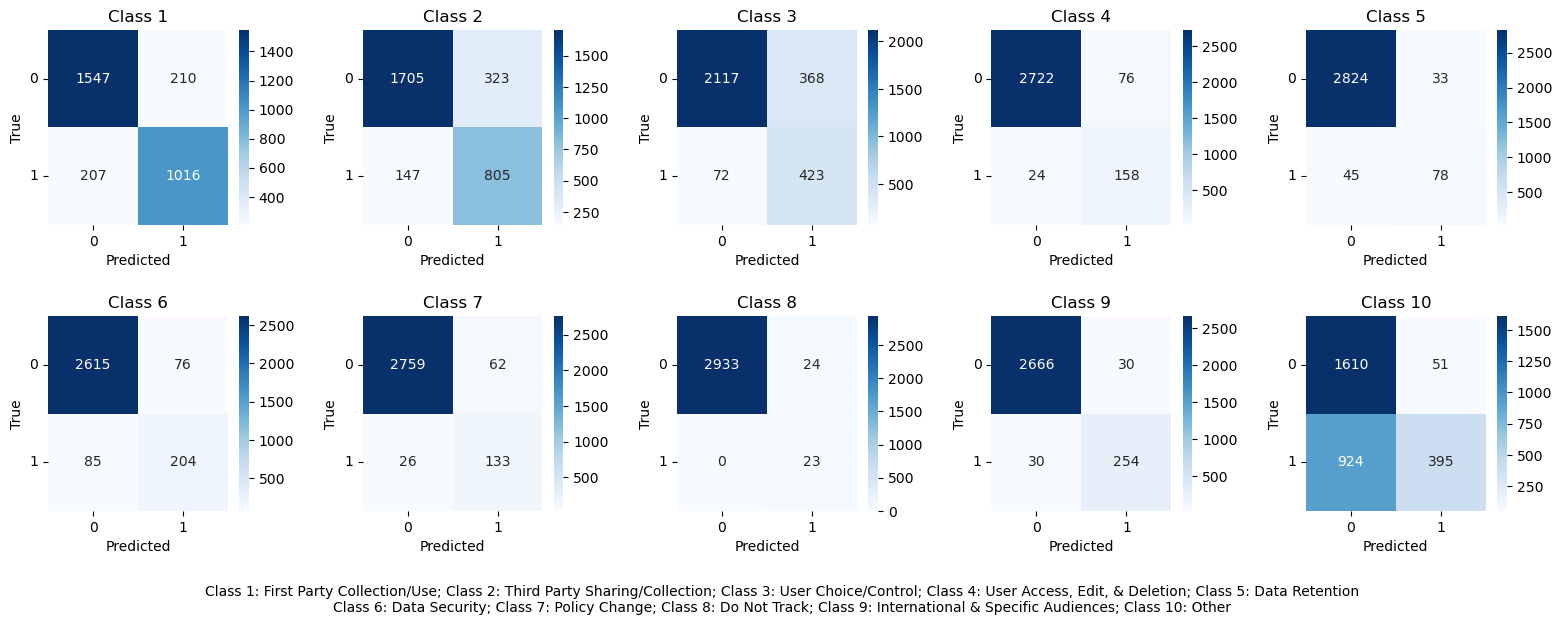

In [13]:
# Generate the multilabel confusion matrix
confusion_matrices = multilabel_confusion_matrix(y_true_binary, y_pred_binary)

fig, axes = plt.subplots(2, 5, figsize=(16, 6))
axes = axes.flatten()

for i, ax in enumerate(axes):
    sns.heatmap(confusion_matrices[i], annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"Class {classes[i]}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.xaxis.set_tick_params(rotation=0)
    ax.yaxis.set_tick_params(rotation=0)


# Add a footer to represent what each class number is
footer_text = "; ".join([f"Class {i+1}: {category_name}" for i, category_name in enumerate(category_names[0:5])])
footer_text += "\n"
footer_text += "; ".join([f"Class {i+6}: {category_name}" for i, category_name in enumerate(category_names[5:10])])
plt.figtext(0.5, -0.05, footer_text, ha="center", fontsize=10)
plt.tight_layout(pad=2.0)
plt.show()

In [14]:
# Calculate accuracy for each class
accuracies = (y_true_binary == y_pred_binary).mean(axis=0)
accuracy_per_class = dict(zip(category_names, accuracies))

accuracy_report = "                                   accuracy\n\n"
for category, accuracy in accuracy_per_class.items():

    accuracy_report += f"{category.rjust(34)} {accuracy:8.2f}\n"

print(accuracy_report)
# Calculate the average accuracy across all classes
average_accuracy = accuracies.mean()
print(f"Average Accuracy: {average_accuracy:.2f}")

                                   accuracy

        First Party Collection/Use     0.86
    Third Party Sharing/Collection     0.84
               User Choice/Control     0.85
     User Access, Edit, & Deletion     0.97
                    Data Retention     0.97
                     Data Security     0.95
                     Policy Change     0.97
                      Do Not Track     0.99
International & Specific Audiences     0.98
                             Other     0.67

Average Accuracy: 0.91


In [15]:
# Generate the classification report
metrics_report = classification_report(y_true_binary, y_pred_binary, target_names=category_names)
print(metrics_report)

                                    precision    recall  f1-score   support

        First Party Collection/Use       0.83      0.83      0.83      1223
    Third Party Sharing/Collection       0.71      0.85      0.77       952
               User Choice/Control       0.53      0.85      0.66       495
     User Access, Edit, & Deletion       0.68      0.87      0.76       182
                    Data Retention       0.70      0.63      0.67       123
                     Data Security       0.73      0.71      0.72       289
                     Policy Change       0.68      0.84      0.75       159
                      Do Not Track       0.49      1.00      0.66        23
International & Specific Audiences       0.89      0.89      0.89       284
                             Other       0.89      0.30      0.45      1319

                         micro avg       0.74      0.69      0.71      5049
                         macro avg       0.71      0.78      0.72      5049
          

In [17]:
# Find mismatches in each category
mismatches = {}

for i, category in enumerate(category_names):
    mismatches[category] = []

    for idx, (true_val, pred_val) in enumerate(zip(y_true_binary[:, i], y_pred_binary[:, i])):
        if true_val != pred_val:
            mismatches[category].append((idx, true_val, pred_val))

# Print mismatches
for category, mismatch_list in mismatches.items():
    print(f"Category: {category}")
    for idx, true_val, pred_val in mismatch_list:
        print(f"Index: {idx}, Actual: {true_val}, Predicted: {pred_val}")
    print("\n")

Category: First Party Collection/Use
Index: 2, Actual: False, Predicted: True
Index: 5, Actual: True, Predicted: False
Index: 20, Actual: True, Predicted: False
Index: 39, Actual: False, Predicted: True
Index: 40, Actual: False, Predicted: True
Index: 44, Actual: True, Predicted: False
Index: 53, Actual: False, Predicted: True
Index: 68, Actual: False, Predicted: True
Index: 72, Actual: False, Predicted: True
Index: 74, Actual: False, Predicted: True
Index: 76, Actual: True, Predicted: False
Index: 80, Actual: False, Predicted: True
Index: 89, Actual: False, Predicted: True
Index: 95, Actual: False, Predicted: True
Index: 110, Actual: False, Predicted: True
Index: 118, Actual: False, Predicted: True
Index: 125, Actual: True, Predicted: False
Index: 130, Actual: True, Predicted: False
Index: 132, Actual: False, Predicted: True
Index: 139, Actual: True, Predicted: False
Index: 147, Actual: False, Predicted: True
Index: 148, Actual: False, Predicted: True
Index: 156, Actual: False, Predic